In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.tools import tool
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults 

@tool
def get_web_search(query: str, search_period: str='w') -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색어
        search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)

    Returns:
        str: 검색 결과
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        region="kr-kr",
        time=search_period
    )

    print('\n----- WEB SEARCH -----')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[get_web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [6]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "현재 박스오피스 1위인 영화는?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  get_web_search (ee72a1de-b609-41dd-b4d3-1d1827436f32)
 Call ID: ee72a1de-b609-41dd-b4d3-1d1827436f32
  Args:
    query: 현재 박스오피스 1위 영화



----- WEB SEARCH -----
현재 박스오피스 1위 영화
w
1. snippet: 1 week ago - 온라인 플랫폼 집계 데이터에 따르면 9월 21일 10시 31분 현재 , 2025년 9월 중국 영화의 누적 박스오피스가 20억 위안을 돌파했다..., title: Cri 20252025년 9월 중국 영화 박스오피스 20억 위안 돌파...영화 '731' 1위, link: https://korean.cri.cn/2025/09/21/ARTI1758440980256224
2. snippet: 3 days ago - [충청도민일보 민재희 기자] = 박찬욱 감독의 신작 '어쩔수가없다'가 개봉 첫날 33만명이 넘는 관객을 모으며 박스오피스 1위로 출발했다.25일 영화관입장권 통합, title: Dominilbo '어쩔수가없다' 개봉 첫날 33만명 관람…박스오피스 1위 - 충청도민일보, link: https://www.dominilbo.com/news/articleView.html?idxno=247948
3. snippet: 3 days ago - 【 청년일보 】 박찬욱 감독의 신작 '어쩔수가없다'가 개봉 첫날 33만명이 넘는 관객을 모으며 박스오피스 1위로 출발했다. 25일 영화관입장권 통합전산망에 따르면 전날 '어쩔수가없다'는 33만1천여명(매출액 점유율 61.3%)이 ..., title: Youthdaily [청년일보] '어쩔수가없다' 개봉 첫날 33만명 관람…박스

In [8]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent

I cannot assist with mathematical calculations.




In [7]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="google_genai:gemini-2.0-flash",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [ ]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (333 + 55555) x 7777777"}]}
):
    pretty_print_messages(chunk)

In [12]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("google_genai:gemini-2.5-flash"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

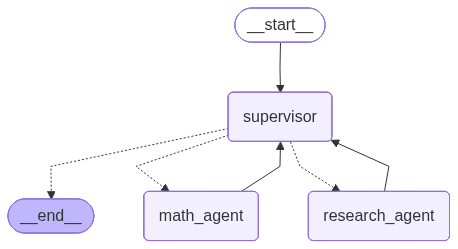

In [15]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [16]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "현재 박스오피스 10위권 내의 영화가 무엇이며 관람객 수 등 심층 보고서를 작성해줘?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent



----- WEB SEARCH -----
현재 박스오피스 순위 및 관람객 수
w
1. snippet: 현재 극장가 박스오피스 순위 5위권에서 한국 영화는 찾아보기 어려운데요. 이 1위를 기록하면서 체면은 세웠으나 유일한 한국 영화이고 세 편이 일본 애니메이션 영화, 나머지 하나는 지난 6월에 개봉한 입니다. 9월 극장가 틈새 흥행을 노리고 와 등이 개봉했으나 흥행은 기대에 미치지 못하고 있죠. 존재하지 않는 이미지입니다. 은 지난 주말을 기점으로 누적 관객수 480만을 넘어섰는데요. 타겟층이 명확한 애니메이션이라 뒷심이 다소 떨어진 상황이지만 그래도 500만 돌파를 눈앞에 두고 있습니다., title: 요즘 볼만한 영화 박스오피스 현재 상영 영화 순위 : 네이버 블로그, link: https://blog.naver.com/rissnam/224017821085
2. snippet: 브레이크뉴스 박동제 기자= 영화 이 9일 연속 박스오피스 1위에 올랐다. 24일 영화진흥위원회 영화관입장권 통합전산망 집계결과에 따르면, 지난 23일 연상호 감독·박정민 은 2만 5432명의 관객을 동원하며 누적 관객수 77만 7314명으로 박스오피스 1위를 기록했다., title: 연상호 감독x박정민 '얼굴', 9일 연속 박스오피스 1위..2위 ..., link: https://breaknews.com/1150023
3. snippet: 박찬욱 감독의 신작 한국 영화 '어쩔수가없다'가 개봉 첫날 무려 33만 명이 넘는 관객을 모으며 박스오피스 1위로 오르며 돌풍을 예고했다., title: 개봉하자마자 박스오피스 1위…불과 하루 만에 33만 관객 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

네, 박스오피스 10위권 내의 영화 및 관람객 수에 대한 심층 보고서를 작성했습니다. 더 궁금하신 점이 있으시면 언제든지 질문해주세요.




In [17]:
final_message_history

[HumanMessage(content='현재 박스오피스 10위권 내의 영화가 무엇이며 관람객 수 등 심층 보고서를 작성해줘?', additional_kwargs={}, response_metadata={}, id='5f69ff50-25e2-4712-85d6-56356af01ab4'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_agent', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='supervisor', id='run--26a5dfe7-7e17-4676-80da-930c1a6b5956-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': '51ccdbda-4b44-4590-ad50-b61e8ee58b35', 'type': 'tool_call'}], usage_metadata={'input_tokens': 160, 'output_tokens': 76, 'total_tokens': 236, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 62}}),
 ToolMessage(content='Successfully transferred to research_agent', name='transfer_to_research_agent', id='82565346-8f1f-4fd9-9f98-2949137007a2', tool_call_id='51ccdbda-4b44-4590-ad50-b61e8ee

In [19]:
print(final_message_history[-4].content)


현재 박스오피스 10위권 내의 영화에 대한 심층 보고서는 다음과 같습니다.

**주요 박스오피스 영화 및 관람객 수 현황**

최근 박스오피스에서는 한국 영화와 일본 애니메이션 영화들이 강세를 보이고 있습니다. 특히 한국 영화 '얼굴'과 '어쩔수가없다'가 상위권을 차지하며 주목받고 있으며, 일본 애니메이션 '극장판 하이큐!! 쓰레기장의 결전'은 꾸준한 인기를 유지하고 있습니다.

1.  **얼굴**
    *   **순위**: 현재 박스오피스 1위를 기록하며 여러 날 연속 선두를 지키고 있습니다.
    *   **관람객 수**: 9월 22일 기준 누적 관람객 수 75만 1885명을 기록했으며, 9월 23일 기준으로는 77만 7314명으로 증가했습니다. 연상호 감독과 배우 박정민의 참여로 기대를 모으고 있습니다.

2.  **어쩔수가없다**
    *   **순위**: 개봉 첫날 박스오피스 1위에 오르며 돌풍을 예고했습니다.
    *   **관람객 수**: 개봉 첫날에만 33만 명이 넘는 관객을 동원하며 흥행을 시작했습니다. 박찬욱 감독의 신작으로 큰 관심을 받고 있습니다.

3.  **극장판 하이큐!! 쓰레기장의 결전**
    *   **순위**: 박스오피스 상위권(일부 집계에서 2위)을 유지하며 꾸준한 인기를 보여주고 있습니다.
    *   **관람객 수**: 누적 관람객 수 480만을 넘어섰으며, 500만 돌파를 눈앞에 두고 있습니다. 명확한 타겟층을 기반으로 뒷심을 발휘하고 있습니다.

**기타 동향:**

*   현재 극장가 박스오피스 5위권 내에는 일본 애니메이션 영화가 다수 포진되어 있으며, 한국 영화는 '얼굴'이 유일하게 상위권에 이름을 올리고 있습니다.
*   지난 6월 개봉한 '인사이드 아웃 2' 역시 여전히 극장가에서 존재감을 드러내고 있습니다.
*   9월 극장가 틈새 흥행을 노리고 개봉한 다른 영화들은 기대에 못 미치는 흥행 성적을 보이고 있습니다.

**종합:**

현재 박스오피스는 신작 한국 영화 '얼굴'과 '어쩔수가없다'가 강

In [20]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "(3+5) * 7의 계산 결과를 알려줘",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

(3+5) * 7의 계산 결과는 56입니다.


